In [458]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [459]:
%matplotlib inline

In [460]:
import matplotlib.pyplot as plt

import numpy as np

import darkhistory.physics as phys
import main
# import darkhistory.history.tla as tla
from scipy import integrate
import scipy.special

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix

The following units are being used
$$
\begin{alignat}{2}
M_0 &= 4 \pi \rho_s r_s^3 \\
t_0 &= (4\pi G \rho_s)^{-1/2} \\ 
\nu_0 &= r_s/t_0 \\
(\sigma/m)_0 &= (r_s \rho_s)^{-1} \\
L_0 &= (4\pi)^{5/2}G^{3/2}\rho_s^{5/2} r_s^5 \\
C_0 &= (4\pi G)^{3/2}\rho_s^{5/2}r_s^2
\end{alignat}
$$
Do we set $\rho_s = r_s = 1$?

In [614]:
13*1e5/phys.c

4.3363332375759766e-05

In [616]:
### Constants ###
#g to kg (1e-3) to J (c^-2) to eV (e^-1)
g_to_eV = 1e-3/phys.c**2/phys.ele
G = 1 #Newton's constant

#Particle Physics
sig_m  = 3*0.0135784 #3/g_to_eV # sigma / m
sigp_m = sig_m
nu_loss = 13*1e5/17098500 #13 km/s


def C(rho,nu):
    ratio = np.divide(nu_loss,nu, where=(nu!=0), out=1e3*np.ones_like(nu))**2
    return rho**2 * sigp_m * 4*nu*nu_loss**2/np.sqrt(np.pi) * (1+ratio) * np.exp(-ratio)
    

def kappa_m(rho, nu, beta=0.6):
    klmfp_m = 0.27 * beta * rho * nu**3 * sig_m
    ksmfp_m = 2.1/sig_m
    mask = klmfp_m==0
    
    k = np.zeros_like(klmfp_m)
    k[~mask] = (klmfp_m[~mask]**(-1) + ksmfp_m**(-1))**(-1)
    return k

def get_L(rho, nu, r):
    T_m = nu**2 # T/m
    dT_mdr = np.append(np.diff(T_m)/np.diff(r), 
                       (T_m[-1]-T_m[-2])/(r[-1]-r[-2]))
    
    return -4*np.pi*r**2 * kappa_m(rho, nu) * dT_mdr
    
def eta(rho, nu,alpha=4/np.sqrt(np.pi)):
    v_bar = np.sqrt(3)*nu
    return 1/3 * alpha*sig_m * v_bar * (
        alpha*sig_m**2 + 4*np.pi*G/rho/nu**2
    )**(-1)

def rho_NFW(r):
    inv = r * (r+1)**2
    return 1/inv

def j_init(r, js=1, r_ratio=3,thetas=1):#theta
    rtmp = r*r_ratio
    return js*(rtmp)**2/(1+rtmp)**4 # * np.sin(theta/thetas)**2

def integrated_NFW(r):
    return 4*np.pi*(np.log(r+1)-r/(r+1))

def nu_ana(r):
    pre = 3*2/r
    term1 = 6 * r**2 * (r+1)**2 * scipy.special.spence(1+r)
    term2p1 = 3 * (r+1) * r**2 * np.log(r+1)**2
    term2p2 = (r+1) * r**2 * (6*np.log(1/r + 1) + 5*np.log(r))
    term2p3 = -np.log(r+1)*(r*(r*(5*r+11)+3)-1)
    term3 = r*(r*(np.pi**2*(r+1)**2 - 7*r - 9) - 1)

    return np.sqrt(
        pre*(term1 + (r+1)*(term2p1+term2p2+term2p3) + term3)
    )

def nu_init(r,rho=None,M=None,switch=False):
    if switch:
        if True:
            nu = np.zeros_like(r)
            grav = M*rho/r**2
            # set the pressure at the edge to zero, 
            # then require that dpdr = -grav

            nu[-1] = nu_ana(r[-1])
            for i in np.arange(len(r)-1):
                nu[-2-i] = np.sqrt((grav[-1-i]*(r[-1-i]-r[-2-i]) 
                                   + rho[-1-i]*nu[-1-i]**2)/rho[-2-i])

            return nu
        else:
            #Initial Condition: at r=0, p=0
            nu = np.zeros_like(r)
            grav = M*rho/r**2
            # set the dispersion at the center to zero
            nu[0] = np.sqrt(grav[0]*(r[0]-0)/rho[0])
            for i in np.arange(len(r)-1):
                nu[i+1] = np.sqrt((rho[i]*nu[i]**2
                    -grav[i+1]*(r[i+1]-r[i]))/rho[i+1])

            return nu
        
    else:
        r_mid = np.append(r[0]/2, (r[:-1]+r[1:])/2)
        return nu_ana(r_mid)
    
    
def p_ana(r):
    return rho_NFW(r)*nu_ana(r)**2

def p_init(r,rho=None,M=None,switch=False):
    r_mid = np.append(r[0]/2, (r[:-1]+r[1:])/2)
    if switch:
        r_ext = np.append(0,r)
        r_diff = (r_ext[2:]-r_ext[:-2])/2
        if True:
            p = np.zeros_like(r)
            rho_av = (rho[:-1]+rho[1:])/2
            dp = M[:-1]/r[:-1]**2 * rho_av * r_diff
            # set the pressure at the edge to zero, 
            # then require that dpdr = -grav

            p[-1] = p_ana(r_mid[-1])
            for i in np.arange(len(r)-1):
                p[-2-i] = p[-1-i]+dp[-1-i]

            return p
        
        else:
            #Initial Condition: at r=0, p=0
            p = np.zeros_like(r)
            grav = M*rho/r**2
            dr = np.diff(r_mid)
            # set the dispersion at the center to zero
            p[0] = p_ana(r_mid[0])
            for i in np.arange(len(r)-1):
                p[i+1] = p[i]-grav[i+1]*dr[i]

            return p
        
    else:
        return p_ana(r_mid)

In [617]:
# Hydrostatic Equilibrium
def get_dr(r, rho, M, p, verbose=False):
    rho_mean = (rho[:-1]+rho[1:])/2
    r_diff = (r[1:]-np.append(0,r[:-2]))/2
    
    dpdr = (p[1:]-p[:-1])/r_diff
    Mm, rr = M[:-1], r[:-1]
    
    drrho = -3*rho/r
    drp = -5*p/r
    
    d = -dpdr - Mm/rr**2 * rho_mean
    
    c = (drp[1:]/r_diff - dpdr/(2*r_diff)
         + Mm/rr**2 * drrho[1:]/2)[:-1]
    
    b = (-drp[:-1]/r_diff - 2*Mm/rr**3*rho_mean 
         + Mm/rr**2 * drrho[:-1]/2)
    
    a = (dpdr/(2*r_diff))[1:]
    
    tri_di = csc_matrix(diags([a,b,c], [-1, 0, 1]))
    
    dr = spsolve(tri_di, d)
    
    dp   = drp[:-1]*dr
    drho = drrho[:-1]*dr
    
    if verbose:
        print('equilibrium: ', np.sqrt(np.sum(d**2)))
    
    return (dr, dp, drho, np.sqrt(np.sum(d**2)))

In [618]:
def rsq_rho_NFW(r):
    return 4*np.pi*r**2 * rho_NFW(r)
print(integrate.quad(rsq_rho_NFW,0,2),integrated_NFW(2))

(5.427988771320028, 7.152737876055877e-11) 5.42798877132003


Manoj + Kim method

In [619]:
#Initialization

N = 400
r = 10**np.arange(-2,2,4/N)
r_mid = np.append(r[0]/2, (r[:-1]+r[1:])/2)

rho = rho_NFW(r_mid) # Use Pippin profile instead
M = integrated_NFW(r)
p = p_init(r, rho, M, switch=True)

# p = rho * nu**2
# nu = nu_init(r, rho, M, switch=True)

# for k in np.arange(10):
#     (dr, dp, drho, err) = get_dr(r, rho, M, p, True)
#     r[:-1]   += dr
#     p[:-1]   += dp
#     rho[:-1] += drho

nu = np.sqrt(p/rho)
tmp = get_dr(r, rho, M, p, True)

equilibrium:  1.729848407956611e-11


In [635]:
rho_NFW(r[0])

98.35014377719061

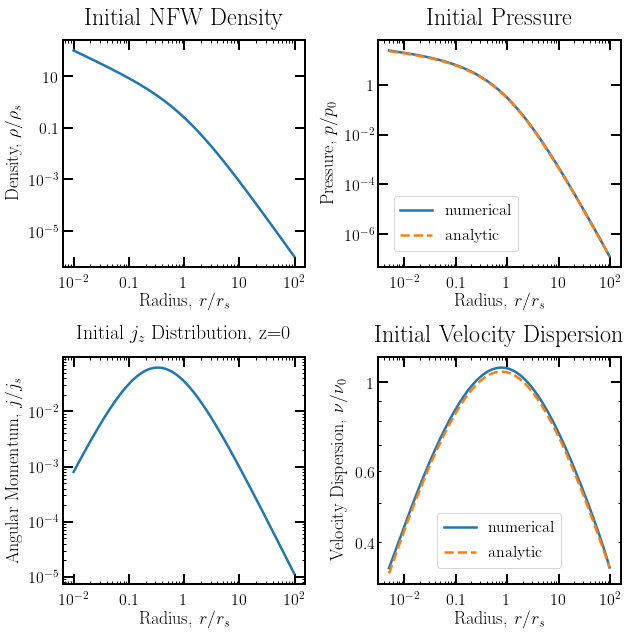

In [620]:
fig, axarr = plt.subplots(2, 2, figsize=(10,10))

axarr[0][0].loglog()
axarr[0][0].plot(r,rho_NFW(r))
axarr[0][0].set_xlabel(r'Radius, $r/r_s$')
axarr[0][0].set_ylabel(r'Density, $\rho/\rho_s$')
axarr[0][0].set_title('Initial NFW Density')

axarr[0][1].loglog()
axarr[0][1].plot(r_mid,p, label='numerical')
# axarr[1].plot(r,rho_NFW(r) * nu**2, label='numerical')
axarr[0][1].plot(r_mid,p_ana(r_mid), label='analytic', linestyle='--')
axarr[0][1].set_xlabel(r'Radius, $r/r_s$')
axarr[0][1].set_ylabel(r'Pressure, $p/p_0$')
axarr[0][1].set_title('Initial Pressure')
axarr[0][1].legend()

axarr[1][0].loglog()
axarr[1][0].plot(r,j_init(r))
axarr[1][0].set_xlabel(r'Radius, $r/r_s$')
axarr[1][0].set_ylabel(r'Angular Momentum, $j/j_s$')
axarr[1][0].set_title('Initial $j_z$ Distribution, z=0', fontsize=20)

axarr[1][1].loglog()
axarr[1][1].plot(r_mid,nu, label='numerical')
axarr[1][1].plot(r_mid,nu_ana(r_mid), label='analytic', linestyle='--')
axarr[1][1].set_xlabel(r'Radius, $r/r_s$')
axarr[1][1].set_ylabel(r'Velocity Dispersion, $\nu/\nu_0$')
axarr[1][1].set_title('Initial Velocity Dispersion')
axarr[1][1].legend()

plt.subplots_adjust(#top=0.92, bottom=0.08, left=0.10, right=0.95,
                    wspace=0.3, hspace=0.4)

In [636]:
N = 400
r = 10**np.arange(-2,2,4/N)
r_mid = np.append(r[0]/2, (r[:-1]+r[1:])/2)

rho = rho_NFW(r_mid) # Use Pippin profile instead
M = integrated_NFW(r)
p = p_init(r, rho, M, switch=True)

rs = np.array([[r]])
ps = np.array([[p]])
rhos = np.array([[rho]])
ts = np.array([0])

## p = rho * nu**2
## nu = nu_init(r, rho, M, switch=True)
## tmp = get_dr(r, rho, M, p, True)

# Loop through
Delta_t = 0
for i in np.arange(1e5):#9e2):
    nu = np.sqrt(p/rho)
    L = get_L(rho, nu, r)
    u = 3*nu**2/2
    du_dt = -(
        np.diff(np.append(0,L))/np.diff(np.append(0,M))
        #+ C(rho,nu)/rho
    )

    # print(np.diff(rho*nu**2)/np.diff(r)/(M*rho/r**2)[1:]+1)

    mask = (u!=0)
    dt = np.min(np.abs(u[mask]/du_dt[mask])*1e-2)
    du = du_dt*dt
    Delta_t += dt

    p =  2/3*rho*(u + du)
    
    err = 1e4
    while err>1e-10:
        (dr, dp, drho, err) = get_dr(r, rho, M, p)
        r[:-1]   += dr
        p[:-1]   += dp
        rho[:-1] += drho
    # print(np.diff(rho*nu_p**2)/np.diff(r)/(M*rho/r**2)[1:]+1)
    
    if np.any(np.isnan(ps)):
        print('NAN')
        break
    
    if i%500 == 0:
        rs   = np.append(rs,np.array([[r]]), axis=1)
        ps   = np.append(ps,np.array([[p]]), axis=1)
        rhos = np.append(rhos,np.array([[rho]]), axis=1)
        ts   = np.append(ts, Delta_t)
        print(i, Delta_t, err)
    
rs   = np.squeeze(rs)
ps   = np.squeeze(ps)
rhos = np.squeeze(rhos)

nus = np.sqrt(ps/rhos)
print(Delta_t, "time elapsed.")

0.0 4.059551605285607e-06 2.6231204568481288e-11
500.0 0.00012177841587905896 2.0190936212828186e-11
1000.0 0.00021941644651071146 2.1994156859709698e-11
1500.0 0.00031500496636318546 2.7887710541163732e-11
2000.0 0.0004088226809463836 2.458980916456527e-11
2500.0 0.0005010604649507897 2.4646247092889205e-11
3000.0 0.0005916216262991827 1.956181887769614e-11
3500.0 0.0006805584391952414 2.1281588482652267e-11
4000.0 0.0007681996644867609 2.3052168802387597e-11
4500.0 0.0008546276417386111 2.5747497170111222e-11
5000.0 0.0009395795304939051 2.1485476515344754e-11
5500.0 0.0010234472884197018 2.6264198581869282e-11
6000.0 0.0011063610877636205 2.523603921049141e-11
6500.0 0.0011880320394394885 1.665271908111261e-11
7000.0 0.001268784046896678 2.5699551675530358e-11
7500.0 0.0013487664210582724 2.1835589676718216e-11
8000.0 0.0014276104338572795 2.430438600577347e-11
8500.0 0.0015057820908010535 2.8566717440261733e-11
9000.0 0.0015832178478820996 2.398249736962937e-11
9500.0 0.00165970672

79500.0 0.011893266835912858 3.1591606377043096e-11
80000.0 0.011982173842426783 2.429723500302075e-11
80500.0 0.012071196908327348 2.9600519933115736e-11
81000.0 0.01216050925790607 3.1995832939990216e-11
81500.0 0.012249852171199631 2.4373807923210824e-11
82000.0 0.012339483389564454 2.8489212821287898e-11
82500.0 0.012429125790048604 3.0031029680160165e-11
83000.0 0.012519014005598286 2.6316940568377177e-11
83500.0 0.012608933948902312 2.3556698761051514e-11
84000.0 0.012698987445853373 2.2598966507688236e-11
84500.0 0.01278916506055985 2.8327608030878868e-11
85000.0 0.012879299975698194 2.6825374212446443e-11
85500.0 0.012969706742902789 2.2813126269337024e-11
86000.0 0.013059863376483061 3.479406655515856e-11
86500.0 0.01315030651191702 2.7111489147324735e-11
87000.0 0.013240625490507701 2.720443296045691e-11
87500.0 0.013330918805914192 2.1345943430600284e-11
88000.0 0.01342136989703655 2.2472839368384803e-11
88500.0 0.013511502575570954 3.432052310409815e-11
89000.0 0.0136017250

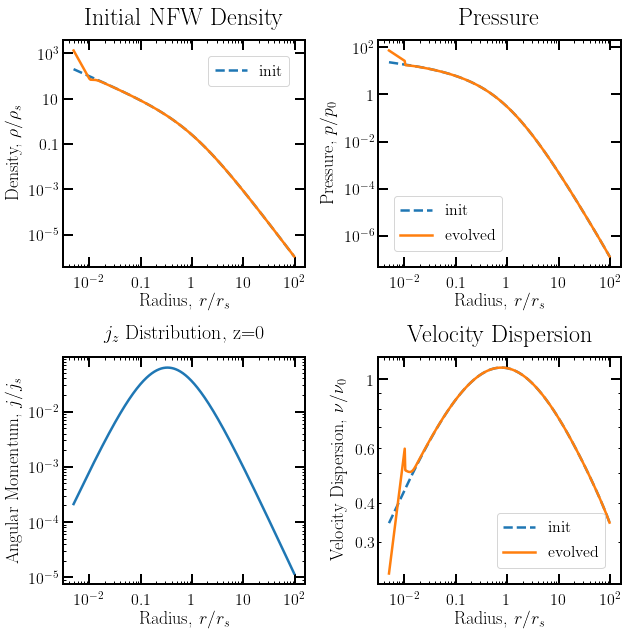

In [637]:
kk=-1

fig, axarr = plt.subplots(2, 2, figsize=(10,10))

axarr[0][0].loglog()
axarr[0][0].plot(r_mid,rhos[0], label='init', linestyle='--')
axarr[0][0].plot(r_mid,rhos[kk])
axarr[0][0].set_xlabel(r'Radius, $r/r_s$')
axarr[0][0].set_ylabel(r'Density, $\rho/\rho_s$')
axarr[0][0].set_title('Initial NFW Density')
axarr[0][0].legend()

axarr[0][1].loglog()

# axarr[1].plot(r,rho_NFW(r) * nu**2, label='numerical')
axarr[0][1].plot(r_mid,ps[0], label='init', linestyle='--')
axarr[0][1].plot(r_mid,ps[kk], label='evolved')
axarr[0][1].set_xlabel(r'Radius, $r/r_s$')
axarr[0][1].set_ylabel(r'Pressure, $p/p_0$')
axarr[0][1].set_title('Pressure')
axarr[0][1].legend()

axarr[1][0].loglog()
axarr[1][0].plot(r_mid,j_init(r_mid))
axarr[1][0].set_xlabel(r'Radius, $r/r_s$')
axarr[1][0].set_ylabel(r'Angular Momentum, $j/j_s$')
axarr[1][0].set_title('$j_z$ Distribution, z=0', fontsize=20)

axarr[1][1].loglog()
axarr[1][1].plot(r_mid,nus[0], label='init', linestyle='--')
axarr[1][1].plot(r_mid,nus[kk], label='evolved')
axarr[1][1].set_xlabel(r'Radius, $r/r_s$')
axarr[1][1].set_ylabel(r'Velocity Dispersion, $\nu/\nu_0$')
axarr[1][1].set_title('Velocity Dispersion')
axarr[1][1].legend()

plt.subplots_adjust(#top=0.92, bottom=0.08, left=0.10, right=0.95,
                    wspace=0.3, hspace=0.4)

In [456]:
Deltat

1.0169999067082798

In [313]:
L = get_L(rho, nu, r)
u = 3*nu**2/2
du_dt = -(
    np.append(np.diff(L)/np.diff(M), (L[-1]-L[-2])/(M[-1]-M[-2]))
    + C(rho,nu)/rho
)

# print(np.diff(rho*nu**2)/np.diff(r)/(M*rho/r**2)[1:]+1)

mask = (u!=0)
dt = np.min(np.abs(u[mask]/du_dt[mask])*1e-3)
du = du_dt*dt

p_new =  2/3*rho*(u + du)

In [270]:
r_new   = r.copy()
pp_new  = p_new.copy()
rho_new = rho.copy()
for i in np.arange(10):
    (dr, dp, drho) = get_dr(r_new, rho_new, M, pp_new, True)

    r_new[:-1]   += dr
    pp_new[:-1]  += dp
    rho_new[:-1] += drho
    # get_dr(r, rho, M, p_new)/r[:-1]

equilibrium:  4.309592853836135
equilibrium:  0.003996590340403774
equilibrium:  1.4048790045736984e-09
equilibrium:  2.33811479374824e-11
equilibrium:  2.8914159445053824e-11
equilibrium:  2.666276587358267e-11
equilibrium:  3.1049193515279966e-11
equilibrium:  2.6714182374678455e-11
equilibrium:  2.889872036468029e-11
equilibrium:  2.1131907440705246e-11


Rouven + Hai-bo method

In [26]:
#Initialize
N = 150
r = 10**np.arange(-2,3,5/N)
rho = rho_NFW(r)
M = integrated_NFW(r)
nu = nu_init(r, rho, M, switch=True)
# print(nu)

L = get_L(rho, nu, r)
u = 3*nu**2/2
du_dt = (
    np.append(np.diff(L)/np.diff(M), (L[-1]-L[-2])/(M[-1]-M[-2]))
    + C(rho,nu)/rho
)

# print(np.diff(rho*nu**2)/np.diff(r)/(M*rho/r**2)[1:]+1)

mask = (u!=0)
dt = np.min(np.abs(u[mask]/du_dt[mask])*1e-3)
du = du_dt*dt

nu_p =  np.sqrt(2/3*(u - du))
# print(np.diff(rho*nu_p**2)/np.diff(r)/(M*rho/r**2)[1:]+1)

In [27]:
# nu_p/nu-1

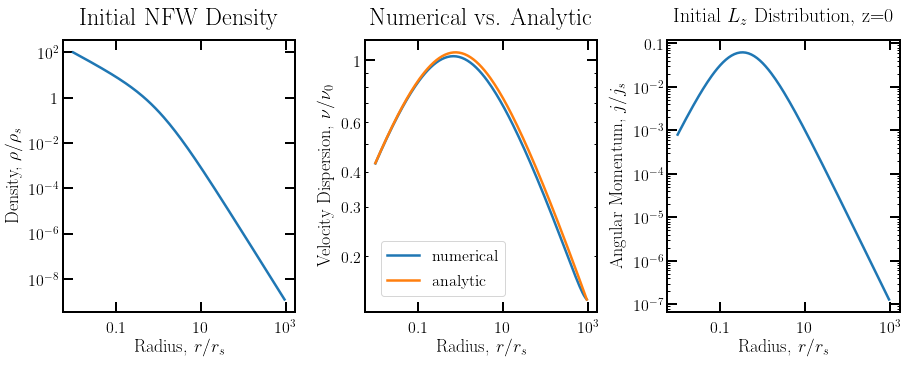

In [28]:
fig, axarr = plt.subplots(1, 3, figsize=(15,5))

axarr[0].loglog()
axarr[0].plot(r,rho_NFW(r))
axarr[0].set_xlabel(r'Radius, $r/r_s$')
axarr[0].set_ylabel(r'Density, $\rho/\rho_s$')
axarr[0].set_title('Initial NFW Density')

axarr[1].loglog()
axarr[1].plot(r,nu, label='numerical')
axarr[1].plot(r,nu_ana(r), label='analytic')
axarr[1].set_xlabel(r'Radius, $r/r_s$')
axarr[1].set_ylabel(r'Velocity Dispersion, $\nu/\nu_0$')
axarr[1].set_title('Numerical vs. Analytic')
axarr[1].legend()

axarr[2].loglog()
axarr[2].plot(r,j_init(r))
axarr[2].set_xlabel(r'Radius, $r/r_s$')
axarr[2].set_ylabel(r'Angular Momentum, $j/j_s$')
axarr[2].set_title('Initial $j_z$ Distribution, z=0', fontsize=20)

plt.subplots_adjust(#top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.3)

In [339]:
dpdr=np.diff(rho*nu**2)/np.diff(r)
# dpdr
print(dpdr+
(M*rho/r**2)[1:])
# dpdr + (M*rho/r**2)[:-1]

[-1.93267624e-12  4.54747351e-13 -1.13686838e-13  1.70530257e-13
 -1.13686838e-12 -5.11590770e-13 -1.13686838e-13  0.00000000e+00
  2.38742359e-12 -9.09494702e-13  2.30215846e-12  3.97903932e-13
  2.01794137e-12  1.19371180e-12  5.68434189e-13 -4.54747351e-13
 -2.27373675e-13 -7.67386155e-13 -2.55795385e-13 -2.27373675e-13
  6.39488462e-13  5.40012479e-13 -2.27373675e-13 -1.27897692e-13
  4.26325641e-13 -1.13686838e-13  0.00000000e+00 -3.05533376e-13
 -1.84741111e-13 -5.68434189e-14  3.55271368e-14  3.55271368e-14
 -9.23705556e-14 -1.31450406e-13  8.52651283e-14  3.55271368e-14
  4.97379915e-14 -4.61852778e-14 -2.13162821e-14 -2.13162821e-14
  3.55271368e-15  3.01980663e-14 -3.55271368e-15  5.32907052e-15
  1.77635684e-15  4.44089210e-15 -7.99360578e-15 -3.55271368e-15
 -7.99360578e-15 -8.43769499e-15  3.10862447e-15  1.33226763e-15
  4.44089210e-16  2.44249065e-15 -1.77635684e-15 -1.77635684e-15
  1.99840144e-15  2.22044605e-15 -9.99200722e-16  7.77156117e-16
 -5.55111512e-17 -1.66533

# Something Else

In [61]:
%autoreload

rs_vec = np.flipud(np.arange(5, 3000, 1))

def func(rs):
    
    if isinstance(rs, np.ndarray):
    
        xe_to_return = np.zeros_like(rs)
        xe_to_return[np.where(rs < 7)] = 1

        return xe_to_return
    
    else:
        
        if rs > 7:
            
            return 0
        
        else:
            
            return 1.

test2 = main.evolve(
    start_rs=3000, coarsen_factor=12,
    DM_process='decay', mDM=2e4, lifetime=1e24, primary='phot_delta',
    reion_switch = True, reion_rs = 7, xe_reion_func=func,
    backreaction=False, compute_fs_method='He'
)

1 1 1 [False  True]
0 0 0 [ True  True]


IndexError: index -1 is out of bounds for axis 0 with size 0

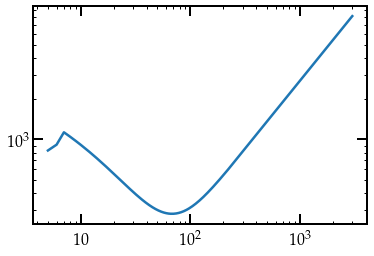

In [51]:
plt.figure()

plt.loglog()

plt.plot(rs_vec, test2[:,0]/phys.kB)

In [53]:
?main.evolve

In [24]:
test

array([[7.04232739e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       [7.04126271e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       [7.03891275e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       ...,
       [9.04744350e-05, 1.90694083e-04, 9.99998695e-13, 9.99998695e-13],
       [6.65100843e-05, 1.88570323e-04, 9.99998695e-13, 9.99998695e-13],
       [4.62064135e-05, 1.86229989e-04, 9.99998695e-13, 9.99998695e-13]])